In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "FALSE"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "20"

In [2]:
import jax
import flax
import jax.numpy as jnp
import flax.linen as nn
import random
import time
from functools import partial
from functools import reduce

import numpy as np
import utils
from matplotlib import pyplot as plt
from einops import rearrange

print('Jax version', jax.__version__)
print('Flax version', flax.__version__)
random_key = jax.random.PRNGKey(42)
random.seed(42)

print("Available devices:", jax.devices())

Jax version 0.4.1
Flax version 0.5.0
Available devices: [StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]


This notebook contains an introduction of the paper [Glow: Generative Flow with Invertible 1×1 Convolutions](https://arxiv.org/pdf/1807.03039.pdf) with an implementation in `jax`. I've also incorporated some of the "tricks" from the authors' original [tensorflow repository](https://github.com/openai/glow/blob/master/model.py#L559), though not all (e.g. of .

In [3]:
class ConvZeros(nn.Module):
    features: int
        
    @nn.compact
    def __call__(self, x, logscale_factor=3.0):
        """A simple convolutional layers initializer to all zeros"""
        x = nn.Conv(self.features, kernel_size=(3, 3),
                    strides=(1, 1), padding='same',
                    kernel_init=jax.nn.initializers.zeros,
                    bias_init=jax.nn.initializers.zeros)(x)
        return x


class Split(nn.Module):
    key: jax.random.PRNGKey = jax.random.PRNGKey(0)
        
    @nn.compact
    def __call__(self, x, reverse=False, z=None, eps=None, temperature=1.0):
        """Args (reverse = True):
            * z: If given, it is used instead of sampling (= deterministic mode).
                This is only used to test the reversibility of the model.
            * eps: If z is None and eps is given, then eps is assumed to be a 
                sample from N(0, 1) and rescaled by the mean and variance of 
                the prior. This is used during training to observe how sampling
                from fixed latents evolve. 
               
        If both are None, the model samples z from scratch
        """
        if not reverse:
            del z, eps, temperature
            z, x = jnp.split(x, 2, axis=-1)
            
        # Learn the prior parameters for z
        prior = ConvZeros(x.shape[-1]*2, name="conv_prior")(x)
            
        # Reverse mode: Only return the output
        if reverse:
            # sample from N(0, 1) prior (inference)
            if z is None:
                if eps is None:
                    eps = jax.random.normal(self.key, x.shape) 
                eps *= temperature
                mu, logsigma = jnp.split(prior, 2, axis=-1)
                z = eps * jnp.exp(logsigma) + mu
            return jnp.concatenate([z, x], axis=-1)
        # Forward mode: Also return the prior as it is used to compute the loss
        else:
            return z, x, prior

In [4]:
class AffineCoupling(nn.Module):
    out_dims : int
    width: int = 512
    eps:float = 1e-8
    ##Get neighbours of the selected patch
        
    @nn.compact
    def __call__(self, inputs, logdet=0, reverse=False, dilation=True, only_neighbours=True):
        
        random_patch = random.randint(0,15)
        # We select one scaled image out of a batch, and now divide it into 16 patches: 
        # for a 32x32 image 1. 8x8 patches - hp=wp=8 for no dilation and for dilation hp=wp=4;
        # for a 64x64 image 1. 8x8 patches - hp=wp=8 for no dilation and for dilation hp=wp=8;
        # for a 64x64 image 2. 16x16 patches - hp=wp=16 for no dilation and for dilation hp=wp=4;
        if only_neighbours:
            neighbours = utils.get_neighbours(random_patch)
        if not dilation:
            all_patches = rearrange(inputs, 'b (nh hp) (nw wp) c -> b (nh nw) hp wp c ', hp=16, wp=16)
        else:
            all_patches = rearrange(inputs, 'b (nh hp) (nw wp) c -> b (hp wp) nh nw c ', hp=4, wp=4)#dilated convolution
            

        chosen_patch = all_patches[:,random_patch,:,:,:] #shape = (batch_size,8,8,3)
        x_rest =  jnp.delete(all_patches,random_patch,axis=1) # (batch_size,15,8,8,3)
        
        net = nn.Conv(features=self.width, kernel_size=(3, 3), strides=(1, 1),
                      padding='same', name="ACL_conv_1")(chosen_patch) # o/p shape = (batch_size,8,8,self.width)
        net = nn.relu(net)
        net = nn.Conv(features=self.width, kernel_size=(1, 1), strides=(1, 1),
                      padding='same', name="ACL_conv_2")(net)
        net = nn.relu(net)
        net = ConvZeros((self.out_dims*2), name="ACL_conv_out")(net) # o/p shape = (batch_size,8,8,6) so that the split of mu and logsigma can make the element wise multiplication possible
        
        if not dilation:
            net = jnp.expand_dims(net,axis=1) #output shape = (batch_size,1,8,8,6)
            
        mu, logsigma = jnp.split(net, 2, axis=-1) # mu and logsigma will be also the same dimension as the to-be-transformed
        sigma = jax.nn.sigmoid(logsigma + 2.)
        
        if not only_neighbours:
            mu = mu.repeat(15, axis=1)
            sigma = sigma.repeat(15, axis=1)
            
            if not reverse:            
                yb = (x_rest * sigma) + mu
                logdet += jnp.sum(jnp.log(sigma), axis=(1, 2, 3, 4))
            else:
                yb = (x_rest - mu) / (sigma + self.eps)
                logdet -= jnp.sum(jnp.log(sigma), axis=(1, 2, 3, 4))
            
            y = jnp.insert(arr=yb,obj=random_patch,values=chosen_patch,axis=1)
                 
        else:
            if not reverse:
                for index in neighbours:
                    all_patches = all_patches.at[:,index,:,:,:].multiply(sigma)
                    all_patches = all_patches.at[:,index,:,:,:].add(mu)
                logdet += jnp.sum(jnp.log(sigma), axis=(1, 2, 3))
            else:
                for index in neighbours:
                    all_patches = all_patches.at[:,index,:,:,:].add(-mu)
                    all_patches = all_patches.at[:,index,:,:,:].divide(sigma+self.eps)
                logdet -= jnp.sum(jnp.log(sigma), axis=(1, 2, 3))
            y = all_patches   

        #Turn patches back to the image - turn back y into (256, 32, 32, 3)
        if not dilation:
            y = rearrange(y, 'b (nh nw) hp wp c -> b (nh hp) (nw wp) c ', nh=4, nw=4) #turn back y into (256, 32, 32, 3)
        else:
            y = rearrange(y, 'b (hp wp) nh nw c -> b (nh hp) (nw wp) c ', hp=4, wp=4) #dilated convolution
            
        return y, logdet


In [58]:
class ActNorm(nn.Module):
    scale: float = 1.
    eps: float = 1e-8

    @nn.compact
    def __call__(self, inputs, logdet=0, reverse=False):
        # Data dependent initialization. Will use the values of the batch
        # given during model.init
        axes = tuple(i for i in range(len(inputs.shape) - 3))
        def dd_mean_initializer(key, shape):
            """Data-dependant init for mu"""
            nonlocal inputs
            x_mean = jnp.mean(inputs, axis=axes, keepdims=True)
            return - x_mean
        
        def dd_stddev_initializer(key, shape):
            """Data-dependant init for sigma"""
            nonlocal inputs
            x_var = jnp.mean(inputs**2, axis=axes, keepdims=True)
            var = self.scale / (jnp.sqrt(x_var) + self.eps)
            return var
        
        # Forward
        shape = (1,) * len(axes) + (inputs.shape[-1],)
        mu = self.param('actnorm_mean', dd_mean_initializer, shape)
        sigma = self.param('actnorm_sigma', dd_stddev_initializer, shape)
        
        logsigma = jnp.log(jnp.abs(sigma))
        # logdet_factor = reduce(
        #     operator.mul, (inputs.shape[i] for i in range(1, len(inputs.shape) - 1)), 1)
        logdet_factor = 1
        if not reverse:
            y = sigma * (inputs + mu)
            logdet += logdet_factor * jnp.sum(logsigma)
        else:
            y = inputs / (sigma + self.eps) - mu
            logdet -= logdet_factor * jnp.sum(logsigma)
        
        # Logdet and return
        return y, logdet

: 

In [34]:
print("Sanity check for data-dependant init in ActNorm")

def sanity_check():
    x = jax.random.normal(random_key, (256, 32, 32, 3))
    model = ActNorm()
    init_variables = model.init(random_key, x)
    y, _ = model.apply(init_variables, x)
    m = jnp.mean(y); v = jnp.std(y); eps = 1e-4
    print("  \033[92m✓\033[0m" if abs(m) < eps else "  \033[91mx\033[0m", "Mean:", m)
    print("  \033[92m✓\033[0m" if abs(v  - 1) < eps else "  \033[91mx\033[0m",
          "Standard deviation", v)
sanity_check()

Sanity check for data-dependant init in ActNorm
  ✓ Mean: -4.4237822e-09
  ✓ Standard deviation 0.9999991


### Invertible Convolution



**Forward**
\begin{align}
y = W x
\end{align}

**Backward**
\begin{align}
x = W^{-1} y
\end{align}


**Log-det:**
$\log \det \mbox{ActNorm} = h \times w \times \sum \log (| \det (W)|)$

In order to make the determinant computation more efficient, the authors propose to work directly with the LU-decomposition of $W$ (*see original paper, section 3.2*), which is initialized as a rotation matrix.

In [35]:
class Conv1x1(nn.Module):
    channels: int
    key: jax.random.PRNGKey = jax.random.PRNGKey(0)

    def setup(self):
        """Initialize P, L, U, s"""
        # W = PL(U + s)
        # Based on https://github.com/openai/glow/blob/master/model.py#L485
        c = self.channels
        # Sample random rotation matrix
        q, _ = jnp.linalg.qr(jax.random.normal(self.key, (c, c)), mode='complete')
        p, l, u = jax.scipy.linalg.lu(q)
        # Fixed Permutation (non-trainable)
        self.P = p
        self.P_inv = jax.scipy.linalg.inv(p)
        # Init value from LU decomposition
        L_init = l
        U_init = jnp.triu(u, k=1)
        s = jnp.diag(u)
        self.sign_s = jnp.sign(s)
        S_log_init = jnp.log(jnp.abs(s))
        self.l_mask = jnp.tril(jnp.ones((c, c)), k=-1)
        self.u_mask = jnp.transpose(self.l_mask)
        # Define trainable variables
        self.L = self.param("L", lambda k, sh: L_init, (c, c))
        self.U = self.param("U", lambda k, sh: U_init, (c, c))
        self.log_s = self.param("log_s", lambda k, sh: S_log_init, (c,))
        
        
    def __call__(self, inputs, logdet=0, reverse=False):
        c = self.channels
        assert c == inputs.shape[-1]
        # enforce constraints that L and U are triangular
        # in the LU decomposition
        L = self.L * self.l_mask + jnp.eye(c)
        U = self.U * self.u_mask + jnp.diag(self.sign_s * jnp.exp(self.log_s))
        logdet_factor = inputs.shape[1] * inputs.shape[2]
        
        # forward
        if not reverse:
            # lax.conv uses weird ordering: NCHW and OIHW
            W = jnp.matmul(self.P, jnp.matmul(L, U))
            y = jax.lax.conv(jnp.transpose(inputs, (0, 3, 1, 2)), 
                             W[..., None, None], (1, 1), 'same')
            y = jnp.transpose(y, (0, 2, 3, 1))
            logdet += jnp.sum(self.log_s) * logdet_factor
        # inverse
        else:
            W_inv = jnp.matmul(jax.scipy.linalg.inv(U), jnp.matmul(
                jax.scipy.linalg.inv(L), self.P_inv))
            y = jax.lax.conv(jnp.transpose(inputs, (0, 3, 1, 2)),
                             W_inv[..., None, None], (1, 1), 'same')
            y = jnp.transpose(y, (0, 2, 3, 1))
            logdet -= jnp.sum(self.log_s) * logdet_factor
            
        return y, logdet

### Wrap-up: Normalizing flow

In [36]:
class FlowStep(nn.Module):
    nn_width: int = 512
    key: jax.random.PRNGKey = jax.random.PRNGKey(0)
        
    @nn.compact
    def __call__(self, x, logdet=0, reverse=False):
        out_dims = x.shape[-1]
        if not reverse:
            x, logdet = ActNorm()(x, logdet=logdet, reverse=False)
            x, logdet = Conv1x1(out_dims, self.key)(x, logdet=logdet, reverse=False)
            x, logdet = AffineCoupling(out_dims, self.nn_width)(x, logdet=logdet, reverse=False)
        else:
            x, logdet = AffineCoupling(out_dims, self.nn_width)(x, logdet=logdet, reverse=True)
            x, logdet = Conv1x1(out_dims, self.key)(x, logdet=logdet, reverse=True)
            x, logdet = ActNorm()(x, logdet=logdet, reverse=True)
        return x, logdet

In [37]:
# Utils to display Jax model in a similar way as flax summary
def get_params_size(v, s=0):
    """Get cumulative size of parameters contained in a FrozenDict"""
    if isinstance(v, flax.core.FrozenDict):
        return s + sum(get_params_size(x)  for x in v.values())
    else:
        return s + v.size

def summarize_jax_model(variables, 
                        max_depth=1, 
                        depth=0,
                        prefix='',
                        col1_size=60,
                        col2_size=30):
    """Print summary of parameters + size contained in a jax model"""
    if depth == 0:
        print('-' * (col1_size + col2_size))
        print("Layer name" + ' ' * (col1_size - 10) + 'Param #')
        print('=' * (col1_size + col2_size))
    for name, v in variables.items():
        if isinstance(v, flax.core.FrozenDict) and depth < max_depth:
            summarize_jax_model(v, max_depth=max_depth, depth=depth + 1, 
                                prefix=f'{prefix}/{name}')
        else:
            col1 = f'{prefix}/{name}'
            col1 = col1[:col1_size] + ' ' * max(0, col1_size - len(col1))
            print(f'{col1}{get_params_size(v)}')
            print('-' * (col1_size + col2_size))
            
# Summarize a flow step
def summary():
    x = jax.random.normal(random_key, (256, 64, 64, 3))
    model = FlowStep(key=random_key)
    init_variables = model.init(random_key, x)
    summarize_jax_model(init_variables, max_depth=2)
summary()

------------------------------------------------------------------------------------------
Layer name                                                  Param #
/params/ActNorm_0/actnorm_mean                              3
------------------------------------------------------------------------------------------
/params/ActNorm_0/actnorm_sigma                             3
------------------------------------------------------------------------------------------
/params/Conv1x1_0/L                                         9
------------------------------------------------------------------------------------------
/params/Conv1x1_0/U                                         9
------------------------------------------------------------------------------------------
/params/Conv1x1_0/log_s                                     3
------------------------------------------------------------------------------------------
/params/AffineCoupling_0/ACL_conv_1                         14336
----------

## Final model

Once we have the flow step definition, we can finally buid the multi-scale Glow architecture. The naming of the different modules is important as it guarantees that the parameters are shared adequately between the forward and reverse pass.

In [38]:
class GLOW(nn.Module):
    K: int = 48                                       # Number of flow steps
    L: int = 1                                        # Number of scales
    nn_width: int = 512                               # NN width in Affine Coupling Layer
    learn_top_prior: bool = False                     # If true, learn prior N(mu, sigma) for zL
    key: jax.random.PRNGKey = jax.random.PRNGKey(42)
        
        
    def flows(self, x, logdet=0, reverse=False, name=""):
        """K subsequent flows. Called at each scale."""
        for k in range(self.K):
            it = k + 1 if not reverse else self.K - k
            x, logdet = FlowStep(self.nn_width, self.key, name=f"{name}/step_{it}")(
                x, logdet=logdet, reverse=reverse)
        return x, logdet
        
    
    @nn.compact
    def __call__(self, x, reverse=False, z=None, eps=None, sampling_temperature=1.0):
        """Args:
            * x: Input to the model
            * reverse: Whether to apply the model or its inverse
            * z (reverse = True): If given, use these as intermediate latents (deterministic)
            * eps (reverse = True, z!=None): If given, use these as Gaussian samples which are later 
                rescaled by the mean and variance of the appropriate prior.
            * sampling_temperature (reverse = True, z!=None): Sampling temperature
        """
        
        ## Inputs
        # Forward pass: Save priors for computing loss
        # Optionally save zs (only used for sanity check of reversibility)
        priors = []
        if not reverse:
            del z, eps, sampling_temperature
            z = []
        # In reverse mode, either use the given latent z (deterministic)
        # or sample them. For the first one, uses the top prior.
        # The intermediate latents are sampled in the `Split(reverse=True)` calls
        else:
            if z is not None:
                assert len(z) == self.L
            else:
                x *= sampling_temperature
                if self.learn_top_prior:
                    # Assumes input x is a sample from N(0, 1)
                    # Note: the inputs to learn the top prior is zeros (unconditioned)
                    # or some conditioning e.g. class information.
                    # If not learnable, the model just uses the input x directly
                    # see https://github.com/openai/glow/blob/master/model.py#L109
                    prior = ConvZeros(x.shape[-1] * 2, name="prior_top")(jnp.zeros(x.shape))
                    mu, logsigma = jnp.split(prior, 2, axis=-1)
                    x = x * jnp.exp(logsigma) + mu
                
        ## Multi-scale model
        logdet = 0
        for l in range(self.L):
            # Forward
            if not reverse:
                x, logdet = self.flows(x, logdet=logdet,
                                       reverse=False,
                                       name=f"flow_scale_{l + 1}/")
                if l < self.L - 1:
                    zl, x, prior = Split(
                        key=self.key, name=f"flow_scale_{l + 1}/")(x, reverse=False)
                else:
                    zl, prior = x, None
                    if self.learn_top_prior:
                        prior = ConvZeros(zl.shape[-1] * 2, name="prior_top")(jnp.zeros(zl.shape))
                z.append(zl)
                priors.append(prior)
                    
            # Reverse
            else:
                if l > 0:
                    x = Split(key=self.key, name=f"flow_scale_{self.L - l}/")(
                        x, reverse=True, 
                        z=z[-l - 1] if z is not None else None,
                        eps=eps[-l - 1] if eps is not None else None,
                        temperature=sampling_temperature)
                x, logdet = self.flows(x, logdet=logdet, reverse=True,
                                       name=f"flow_scale_{self.L - l}/")
                
        ## Return
        return x, z, logdet, priors

In [39]:
print("Sanity check for reversibility (no sampling in reverse pass)")

def sanity_check():
    # Input
    x_1 = jax.random.normal(random_key, (256, 64, 64, 3))
    K, L = 48, 1
    model = GLOW(K=K, L=L, nn_width=512, key=random_key, learn_top_prior=True)
    init_variables = model.init(random_key, x_1)

    # Forward call
    _, z, logdet, priors = model.apply(init_variables, x_1)

    # Check output shape
    expected_h = x_1.shape[1]
    expected_c = x_1.shape[-1]
    print("  \033[92m✓\033[0m" if z[-1].shape[1] == expected_h and z[-1].shape[-1] == expected_c 
          else "  \033[91mx\033[0m",
          "Forward pass output shape is", z[-1].shape)

    # Check sizes of the intermediate latent
    correct_latent_shapes = True
    correct_prior_shapes = True
    for i, (zi, priori) in enumerate(zip(z, priors)):
        expected_h = x_1.shape[1]
        expected_c = x_1.shape[-1]
        if zi.shape[1] != expected_h or zi.shape[-1] != expected_c:
            correct_latent_shapes = False
        if priori.shape[1] != expected_h or priori.shape[-1] != 2*expected_c:
            correct_prior_shapes = False
    print("  \033[92m✓\033[0m" if correct_latent_shapes else "  \033[91mx\033[0m",
          "Check intermediate latents shape")
    print("  \033[92m✓\033[0m" if correct_latent_shapes else "  \033[91mx\033[0m",
          "Check intermediate priors shape")

    # Reverse the network without sampling
    x_3, *_ = model.apply(init_variables, z[-1], z=z, reverse=True)

    print("  \033[92m✓\033[0m" if np.array_equal(x_1.shape, x_3.shape) else "  \033[91mx\033[0m", 
          "Reverse pass output shape = Original shape =", x_1.shape)
    diff = jnp.mean(jnp.abs(x_1 - x_3))
    print("  \033[92m✓\033[0m" if diff < 1e-4 else "  \033[91mx\033[0m", 
          f"Diff between x and Glow_r o Glow (x) = {diff:.3e}")
sanity_check()

Sanity check for reversibility (no sampling in reverse pass)
  ✓ Forward pass output shape is (256, 64, 64, 3)
  ✓ Check intermediate latents shape
  ✓ Check intermediate priors shape
  ✓ Reverse pass output shape = Original shape = (256, 64, 64, 3)
  x Diff between x and Glow_r o Glow (x) = 2.361e-01


# Training the model

## Training loss

### Latent Log-likelihood
Following equation (1), we now only need to compute the likelihood of the latent variables, $\log p(z)$ term; The remaining loss term is computed by accumulating the log-determinant when passing through every block of the normalizing flow.

Since each $p(z)$ is a Gaussian by definition, the corresponding likelihood is easy to estimate:

In [40]:
@jax.vmap
def get_logpz(z, priors):
    logpz = 0
    for zi, priori in zip(z, priors):
        if priori is None:
            mu = jnp.zeros(zi.shape)
            logsigma = jnp.zeros(zi.shape)
        else:
            mu, logsigma = jnp.split(priori, 2, axis=-1)
        logpz += jnp.sum(- logsigma - 0.5 * jnp.log(2 * jnp.pi) 
                         - 0.5 * (zi - mu) ** 2 / jnp.exp(2 * logsigma))
    return logpz

**Note on jax.vmap:** The `vmap` function decorator can be used to indicate that a function should be vectorized across a given axis of its inputs (default is first axis). This is very useful to model a function that can be parallelized across a batch, e.g. a loss function like here or metrics.

### Dequantization

In [A note on the evaluation of generative models](https://arxiv.org/pdf/1511.01844.pdf), the authors observe that typical generative models work with probability densities, considering images as continuous variables, even though images are typically discrete inputs in [0; 255]. A common technique to *dequantize* the data, is to add some small uniform noise to the input training images, which we can incorporate in the output pipeline.

In the original Glow implementation, they also introduce a `num_bits` parameter which allows for further controlling the quantization level of the input images (8 = standard `uint8`, 0 = binary images)

In [41]:
def map_fn(image_path, num_bits=5, size=256, training=True):
    """Read image file, quantize and map to [-0.5, 0.5] range.
    If num_bits = 8, there is no quantization effect."""
    image = tf.io.decode_jpeg(tf.io.read_file(image_path))
    # Resize input image
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (size, size))
    image = tf.clip_by_value(image, 0., 255.)
    # Discretize to the given number of bits
    if num_bits < 8:
        image = tf.floor(image / 2 ** (8 - num_bits))
    # Send to [-1, 1]
    num_bins = 2 ** num_bits
    image = image / num_bins - 0.5
    if training:
        image = image + tf.random.uniform(tf.shape(image), 0, 1. / num_bins)
    return image


@jax.jit
def postprocess(x, num_bits):
    """Map [-0.5, 0.5] quantized images to uint space"""
    num_bins = 2 ** num_bits
    x = jnp.floor((x + 0.5) * num_bins)
    x *= 256. / num_bins
    return jnp.clip(x, 0, 255).astype(jnp.uint8)

**Note on jax.jit**: The `jit` decorator is essentially an optimization that compiles a block of operations acting on the same device together. See also the [jax doc](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html)

## Sampling

Drawing a parallel to the standard VAE, we can see the *encoder* as a forward pass of the Glow module, and the *decoder* as a reverse pass (Glow$^{-1}$).  However, due to the reversible nature of the network, we do not actually need the reverse pass to compute the exact training objective, $p(x)$ as it depends only on the prior $p(z)$, and from the log-determinants of the normalizing flows leading from $x$ to $z$.

In other words, we only need the encoder for the training phase. The "decoder" (i.e., reverse Glow) is used for sampling only. A sampling pass is thus:

In [42]:
def sample(model, 
           params, 
           eps=None, 
           shape=None, 
           sampling_temperature=1.0, 
           key=jax.random.PRNGKey(0),
           postprocess_fn=None, 
           save_path=None,
           display=True):
    """Sampling only requires a call to the reverse pass of the model"""
    if eps is None:
        zL = jax.random.normal(key, shape) 
    else: 
        zL = eps[-1]
    y, *_ = model.apply(params, zL, eps=eps, sampling_temperature=sampling_temperature, reverse=True)
    if postprocess_fn is not None:
        y = postprocess_fn(y)
    plot_image_grid(y, save_path=save_path, display=display,
                    title=None if save_path is None else save_path.rsplit('.', 1)[0].rsplit('/', 1)[1])
    return y


from mpl_toolkits.axes_grid1 import ImageGrid
def plot_image_grid(y, title=None, display=True, save_path=None, figsize=(10, 10)):
    """Plot and optionally save an image grid with matplotlib"""
    fig = plt.figure(figsize=figsize)
    num_rows = int(np.floor(np.sqrt(y.shape[0])))
    grid = ImageGrid(fig, 111, nrows_ncols=(num_rows, num_rows), axes_pad=0.1)
    for ax in grid: 
        ax.set_axis_off()
    for ax, im in zip(grid, y):
        ax.imshow(im)
    fig.suptitle(title, fontsize=18)
    fig.subplots_adjust(top=0.98)
    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight")
    if display:
        plt.show()
    else:
        plt.close()

## Training loop

In [43]:
def train_glow(train_ds,
               val_ds=None,
               num_samples=9,
               image_size=256,
               num_channels=3,
               num_bits=5,
               init_lr=1e-3,
               num_epochs=1,
               num_sample_epochs=1,
               num_warmup_epochs=10,
               num_save_epochs=1,
               steps_per_epoch=1,
               K=32,
               L=3,
               nn_width=512,
               sampling_temperature=0.7,
               learn_top_prior=True,
               key=jax.random.PRNGKey(0),
               **kwargs):
    """Simple training loop.
    Args:
        train_ds: Training dataset iterator (e.g. tensorflow dataset)
        val_ds: Validation dataset (optional)
        num_samples: Number of samples to generate at each epoch
        image_size: Input image size
        num_channels: Number of channels in input images
        num_bits: Number of bits for discretization
        init_lr: Initial learning rate (Adam)
        num_epochs: Numer of training epochs
        num_sample_epochs: Visualize sample at this interval
        num_warmup_epochs: Linear warmup of the learning rate to init_lr
        num_save_epochs: save mode at this interval
        steps_per_epochs: Number of steps per epochs
        K: Number of flow iterations in the GLOW model
        L: number of scales in the GLOW model
        nn_width: Layer width in the Affine Coupling Layer
        sampling_temperature: Smoothing temperature for sampling from the 
            Gaussian priors (1 = no effect)
        learn_top_prior: Whether to learn the prior for highest latent variable zL.
            Otherwise, assumes standard unit Gaussian prior
        key: Random seed
    """
    del kwargs
    # Init model
    model = GLOW(K=K,
                 L=L, 
                 nn_width=nn_width, 
                 learn_top_prior=learn_top_prior,
                 key=key)
    
    # Init optimizer and learning rate schedule
    params = model.init(random_key, next(train_ds))
    opt = flax.optim.Adam(learning_rate=init_lr).create(params)
    
    def lr_warmup(step):
        return init_lr * jnp.minimum(1., step / (num_warmup_epochs * steps_per_epoch + 1e-8))
    
    # Helper functions for training
    bits_per_dims_norm = np.log(2.) * num_channels * image_size**2
    @jax.jit
    def get_logpx(z, logdets, priors):
        logpz = get_logpz(z, priors)
        logpz = jnp.mean(logpz) / bits_per_dims_norm        # bits per dimension normalization
        logdets = jnp.mean(logdets) / bits_per_dims_norm
        logpx = logpz + logdets - num_bits                  # num_bits: dequantization factor
        return logpx, logpz, logdets
        
    @jax.jit
    def train_step(opt, batch):
        def loss_fn(params):
            _, z, logdets, priors = model.apply(params, batch, reverse=False)
            logpx, logpz, logdets = get_logpx(z, logdets, priors)
            return - logpx, (logpz, logdets)
        logs, grad = jax.value_and_grad(loss_fn, has_aux=True)(opt.target)
        opt = opt.apply_gradient(grad, learning_rate=lr_warmup(opt.state.step))
        return logs, opt
    
    # Helper functions for evaluation 
    @jax.jit
    def eval_step(params, batch):
        _, z, logdets, priors = model.apply(params, batch, reverse=False)
        return - get_logpx(z, logdets, priors)[0]
    
    # Helper function for sampling from random latent fixed during training for comparison
    eps = []
    if not os.path.exists("samples"): os.makedirs("samples")
    if not os.path.exists("weights"): os.makedirs("weights")
    for i in range(L):
        expected_h = image_size
        expected_c = num_channels
        eps.append(jax.random.normal(key, (num_samples, expected_h, expected_h, expected_c)))
    sample_fn = partial(sample, eps=eps, key=key, display=False,
                        sampling_temperature=sampling_temperature,
                        postprocess_fn=partial(postprocess, num_bits=num_bits))
    
    # Train
    print("Start training...")
    print("Available jax devices:", jax.devices())
    print()
    bits = 0.
    start = time.time()
    try:
        for epoch in range(num_epochs):
            # train
            for i in range(steps_per_epoch):
                batch = next(train_ds)
                loss, opt = train_step(opt, batch)
                print(f"\r\033[92m[Epoch {epoch + 1}/{num_epochs}]\033[0m"
                      f"\033[93m[Batch {i + 1}/{steps_per_epoch}]\033[0m"
                      f" loss = {loss[0]:.5f},"
                      f" (log(p(z)) = {loss[1][0]:.5f},"
                      f" logdet = {loss[1][1]:.5f})", end='')
                if np.isnan(loss[0]):
                    print("\nModel diverged - NaN loss")
                    return None, None
                
                step = epoch * steps_per_epoch + i + 1
                if step % int(num_sample_epochs * steps_per_epoch) == 0:
                    sample_fn(model, opt.target, 
                              save_path=f"samples/step_{step:05d}.png")

            # eval on one batch of validation samples 
            # + generate random sample
            t = time.time() - start
            if val_ds is not None:
                bits = eval_step(opt.target, next(val_ds))
            print(f"\r\033[92m[Epoch {epoch + 1}/{num_epochs}]\033[0m"
                  f"[{int(t // 3600):02d}h {int((t % 3600) // 60):02d}mn]"
                  f" train_bits/dims = {loss[0]:.3f},"
                  f" val_bits/dims = {bits:.3f}" + " " * 50)
            
            # Save parameters
            if (epoch + 1) % num_save_epochs == 0 or epoch == num_epochs - 1:
                with open(f'weights/model_epoch={epoch + 1:03d}.weights', 'wb') as f:
                    f.write(flax.serialization.to_bytes(opt.target))
    except KeyboardInterrupt:
        print(f"\nInterrupted by user at epoch {epoch + 1}")
        
    # returns final model and parameters
    return model, opt.target

**Note on multi-devices training:** To extend the code for training on multi-devices we can make use of the `jax.vmap` operator (parallelize across XLA devices) instead of `jax.jit`, we also need to share the current parameters with all the devices (use `flax.jax_utils.replicate` on the optimizer before training), and finally to split the data across the devices, which can be handled with the `tf.data` in the input pipeline. [There is a more complete tutorial with an example here](https://flax.readthedocs.io/en/stable/howtos/ensembling.html)

# Experiments

**Note:** We run for 12 epochs due to time limits (roughly 40k training steps) + smaller flow depth (*K*) to fit into single GPU memory

In [45]:
# Data hyperparameters for 1 GPU training
# Some small changes to the original model so 
# everything fits in memory
# In particular, I had  to use shallower
# flows (smaller K value)
config_dict = {
    'image_path': "/dhc/home/sakshi.sangtani/lfw/lfw-deepfunneled/lfw-deepfunneled/*",
    'train_split': 0.8,
    'image_size': 64,
    'num_channels': 3,
    'num_bits': 8,
    'batch_size': 256,
    'K': 48,
    'L': 1,
    'nn_width': 512, 
    'learn_top_prior': True,
    'sampling_temperature': 0.7,
    'init_lr': 1e-5,
    'num_epochs': 10,
    'num_warmup_epochs': 3,
    'num_sample_epochs': 0.2, # Fractional epochs for sampling because one epoch is quite long 
    'num_save_epochs': 5,
}

output_hw = config_dict["image_size"] // 2 ** config_dict["L"]
output_c = config_dict["num_channels"] * 4**config_dict["L"] // 2**(config_dict["L"] - 1)
config_dict["sampling_shape"] = (output_hw, output_hw, output_c)

## Loading the data

In [49]:
import glob
import tensorflow as tf
import tensorflow_datasets as tfds
tf.config.experimental.set_visible_devices([], 'GPU')

def get_train_dataset(img_data,image_size, num_bits, batch_size, skip=None, **kwargs):
    del kwargs
    train_ds = img_data
    if skip is not None:
        train_ds = train_ds.skip(skip)
    train_ds = train_ds.shuffle(buffer_size=200)
    train_ds = train_ds.map(partial(utils.map_fn, size=image_size, num_bits=num_bits, training=True))
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.repeat()
    return iter(tfds.as_numpy(train_ds))


def get_val_dataset(img_data,image_size, num_bits, batch_size, 
                    take=None, repeat=False, **kwargs):
    del kwargs
    val_ds = img_data
    if take is not None:
        val_ds = val_ds.take(take)
    val_ds = val_ds.map(partial(utils.map_fn, size=image_size, num_bits=num_bits, training=False))
    val_ds = val_ds.batch(batch_size)
    if repeat:
        val_ds = val_ds.repeat()
    return iter(tfds.as_numpy(val_ds))

10586 training images
2647 validation images
51 training steps per epoch


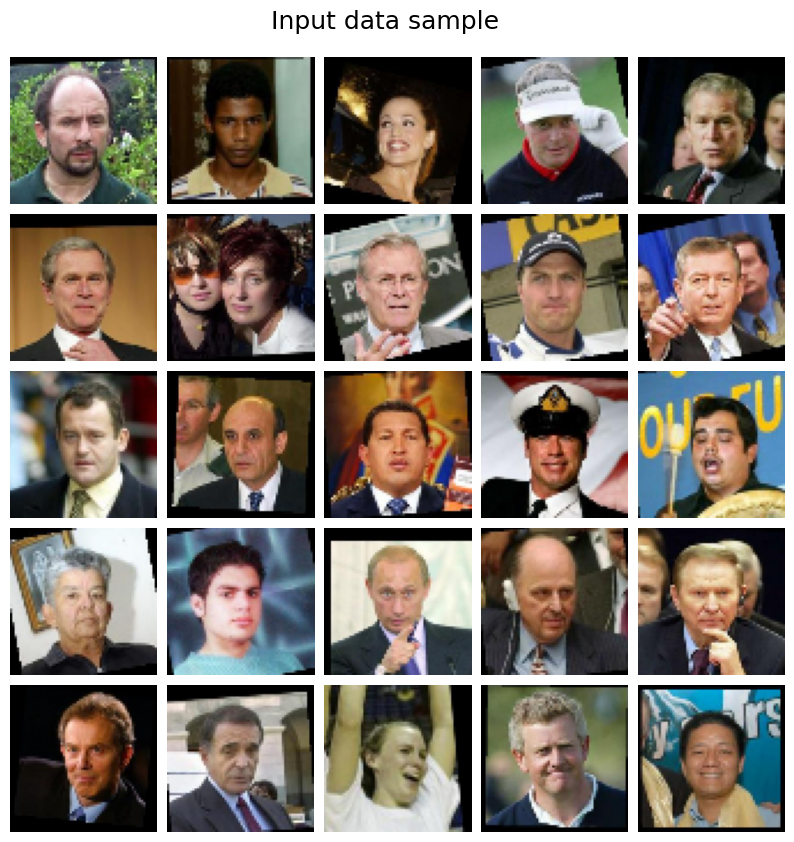

CPU times: user 3.98 s, sys: 2.34 s, total: 6.32 s
Wall time: 11.5 s


In [52]:
%%time
num_images = len(glob.glob(f"{config_dict['image_path']}/*.jpg"))
config_dict['steps_per_epoch'] = num_images // config_dict['batch_size']
train_split = int(config_dict['train_split'] * num_images)
val_split = (num_images-train_split)
print(f"{train_split} training images")
print(f"{val_split} validation images")
print(f"{config_dict['steps_per_epoch']} training steps per epoch")

data = tf.data.Dataset.list_files(f"{config_dict['image_path']}/*.jpg")
data = data.shuffle(buffer_size=800)

# Get the training data and skip the first 20% of the data
train_ds = get_train_dataset(data,**config_dict, skip=val_split)

# Val data
# During training we'll only evaluate on one batch of validation to save on computations
# takes the first 20% of the data that the training set skipped
val_ds = get_val_dataset(data,**config_dict, take=val_split, repeat=True)

# Sample
plot_image_grid(postprocess(next(val_ds), num_bits=config_dict['num_bits'])[:25], 
  title="Input data sample",display=True)

## Train

In [53]:
model, params = train_glow(train_ds, val_ds=val_ds, **config_dict)

/dhc/home/sakshi.sangtani/conda3/envs/jax_310/lib/python3.10/site-packages/flax/optim/base.py:49: DeprecationWarning: Use `optax` instead of `flax.optim`. Refer to the update guide https://flax.readthedocs.io/en/latest/howtos/optax_update_guide.html for detailed instructions.
  warnings.warn(


Start training...
Available jax devices: [StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]



/dhc/home/sakshi.sangtani/conda3/envs/jax_310/lib/python3.10/site-packages/flax/core/scope.py:740: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  abs_value_flat = jax.tree_leaves(abs_value)
/dhc/home/sakshi.sangtani/conda3/envs/jax_310/lib/python3.10/site-packages/flax/core/scope.py:741: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  value_flat = jax.tree_leaves(value)
/dhc/home/sakshi.sangtani/conda3/envs/jax_310/lib/python3.10/site-packages/flax/optim/base.py:90: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  params_flat, treedef = jax.tree_flatten(params)
/dhc/home/sakshi.sangtani/conda3/envs/jax_310/lib/python3.10/site-packages/flax/optim/base.py:97: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Us

[Epoch 1/10][00h 04mn] train_bits/dims = 10.257, val_bits/dims = 10.406                                                  
[Epoch 2/10][00h 07mn] train_bits/dims = 10.022, val_bits/dims = 10.380                                                  
[Epoch 3/10][00h 10mn] train_bits/dims = 9.860, val_bits/dims = 10.994                                                  
[Epoch 4/10][00h 13mn] train_bits/dims = 9.735, val_bits/dims = 13.052                                                  
[Epoch 5/10][Batch 11/51] loss = 9.76097, (log(p(z)) = -1.51436, logdet = -0.24661)
Interrupted by user at epoch 5


In [54]:
print("Random samples evolution during training")
from PIL import Image

# filepaths
fp_in = "samples/step_*.png"
fp_out = "sample_evolution.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=200, loop=0)

from IPython.core.display import display, HTML
display(HTML('<img src="sample_evolution.gif">'))

Random samples evolution during training


/tmp/ipykernel_4178213/3384772220.py:13: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


### Evaluation

In [ ]:
# Optional, example code to load trained weights
if False:
    model = GLOW(K=config_dict['K'],
                 L=config_dict['L'], 
                 nn_width=config_dict['nn_width'], 
                 learn_top_prior=config_dict['learn_top_prior'])

    with open('weights/model_epoch=100.weights', 'rb') as f:
        params = model.init(random_key, jnp.zeros((config_dict['batch_size'],
                                                     config_dict['image_size'],
                                                     config_dict['image_size'],
                                                     config_dict['num_channels'])))
        params = flax.serialization.from_bytes(params, f.read())

In [55]:
def reconstruct(model, params, batch):
    global config_dict
    x, z, logdets, priors = model.apply(params, batch, reverse=False)
    rec, *_ = model.apply(params, z[-1], z=z, reverse=True)
    rec = postprocess(rec, config_dict["num_bits"])
    plot_image_grid(postprocess(batch, config_dict["num_bits"]), title="original")
    plot_image_grid(rec, title="reconstructions")
    

def interpolate(model, params, batch, num_samples=16):
    global config_dict
    i1, i2 = np.random.choice(range(batch.shape[0]), size=2, replace=False)
    in_ = np.stack([batch[i1], batch[i2]], axis=0)
    x, z, logdets, priors = model.apply(params, in_, reverse=False)
    # interpolate
    interpolated_z = []
    for zi in z:
        z_1, z_2 = zi[:2]
        interpolate = jnp.array([t * z_1 + (1 - t) * z_2 for t in np.linspace(0., 1., 16)])
        interpolated_z.append(interpolate)
    rec, *_ = model.apply(params, interpolated_z[-1], z=interpolated_z, reverse=True)
    rec = postprocess(rec, config_dict["num_bits"])
    plot_image_grid(rec, title="Linear interpolation")

### Reconstructions
As a sanity check let's first look at image reconstructions: since the model is invertible these should always be perfect, up to small float errors, except in very bad cases e.g. NaN values or other numerical errors

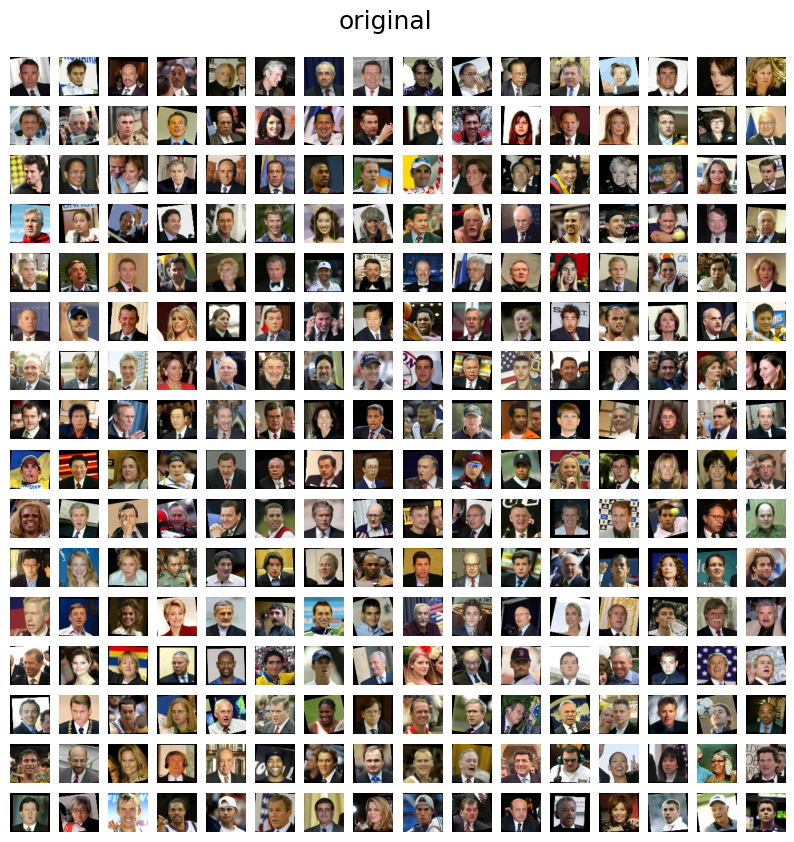

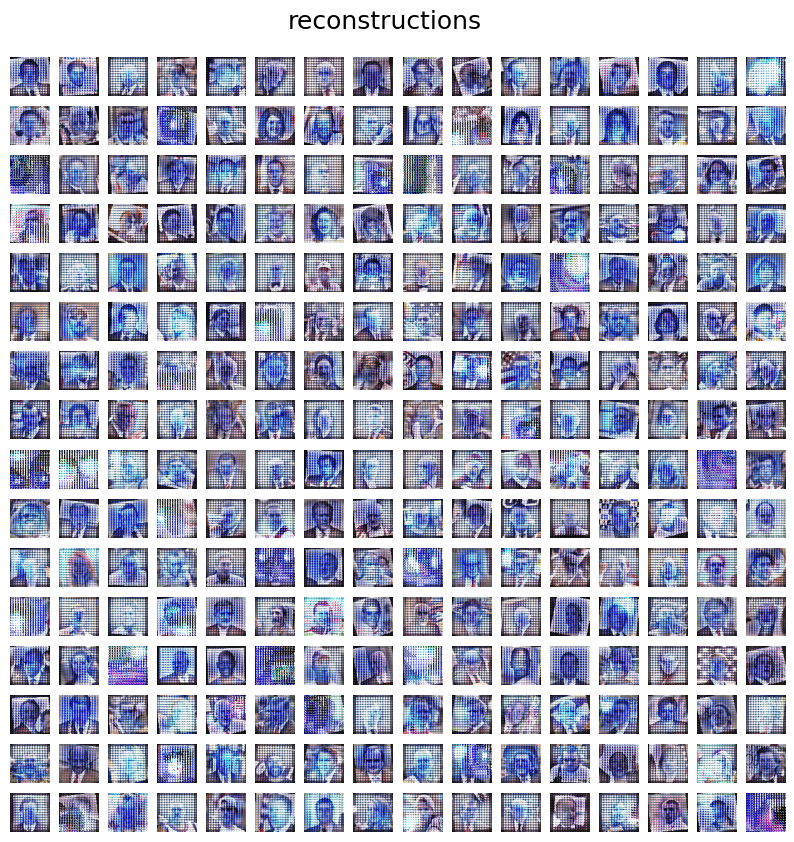

In [56]:
batch = next(val_ds)
reconstruct(model, params, batch)

### Sampling
Now let's take some random samples from the model, starting from the learned priors

In [57]:
sample(model, params, shape=(16,) + config_dict["sampling_shape"],  key=random_key,
       postprocess_fn=partial(postprocess, num_bits=config_dict["num_bits"]),
       save_path="samples/final_random_sample_T=1.png");

ScopeParamShapeError: Inconsistent shapes between value and initializer for parameter "kernel" in "/prior_top/Conv_0": (3, 3, 3, 6), (3, 3, 12, 24). (https://flax.readthedocs.io/en/latest/flax.errors.html#flax.errors.ScopeParamShapeError)

In [ ]:
sample(model, params, shape=(16,) + config_dict["sampling_shape"], 
       key=jax.random.PRNGKey(1), sampling_temperature=0.7,
       postprocess_fn=partial(postprocess, num_bits=config_dict["num_bits"]),
       save_path="samples/final_random_sample_T=0.7.png");

In [ ]:
sample(model, params, shape=(16,) + config_dict["sampling_shape"], 
       key=jax.random.PRNGKey(2), sampling_temperature=0.7,
       postprocess_fn=partial(postprocess, num_bits=config_dict["num_bits"]),
       save_path="samples/final_random_sample_T=0.7.png");

In [ ]:
sample(model, params, shape=(16,) + config_dict["sampling_shape"], 
       key=jax.random.PRNGKey(3), sampling_temperature=0.5,
       postprocess_fn=partial(postprocess, num_bits=config_dict["num_bits"]),
       save_path="samples/final_random_sample_T=0.5.png");

### Latent space
Finally, we can look at the linear interpolation in the learned latent space: We generate embedding $z_1$ and $z_2$ by feeding two validation set images to Glow. Then we plot the decoded images for latent vectors $t + z_1 + (1 - t) z_2$ for $t \in [0, 1]$ (at all level of the latent hierarchy).

**Note on conditional modeling**  The model can also be extented to conditional generation (in the original code this is done by (i) learning the top prior from one-hot class embedding rather than all zeros input, and (ii) adding a small classifier on top of the output latent which should aim at predicting the correct class).

In the original paper, this allows them to do "semantic manipulation" on the Celeba dataset by building representative centroid vectors for different attributes/classes (e.g.g $z_{smiling}$ and $z_{non-smiling}$). They can use then use the vector direction $z_{smiling}$ - $z_{non-smiling}$ as a guide to browse the latent space (in that example, to make images more or less "smiling").

In [ ]:
interpolate(model, params, batch)

In [ ]:
interpolate(model, params, batch)